# Task 3: Customer Segmentation / Clustering

In [188]:
#Importing libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score, adjusted_rand_score, v_measure_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [189]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [190]:
# Merge customer features with transaction features to retain all customers
customer_features_merged = pd.merge(customer_features, transaction_features, on='CustomerID', how='left')

# Aggregate transaction data by customer
customer_agg = customer_features_merged.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'ProductID': 'nunique'
}).reset_index()

# Rename the columns
customer_agg.rename(columns={'ProductID': 'UniqueProducts'}, inplace=True)
customer_agg['Quantity'].fillna(0, inplace=True)
customer_agg['TotalValue'].fillna(0, inplace=True)
customer_agg['UniqueProducts'].fillna(0, inplace=True)



(200, 2)
(200, 4)


In [207]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data_encoded.drop('CustomerID', axis=1))

pca = PCA(n_components=3)  # Retain 3 components for 3D visualization
pca_features = pca.fit_transform(scaled_features)


In [192]:
# Merge customer profile data with aggregated transaction data
merged_data = pd.merge(customer_features, customer_agg, on='CustomerID')

# Encode categorical variables
merged_data_encoded = pd.get_dummies(merged_data, columns=['Region'])
merged_data_encoded['TotalValue'] = np.log1p(merged_data_encoded['TotalValue'])
merged_data_encoded['Quantity'] = np.log1p(merged_data_encoded['Quantity'])
merged_data_encoded.head()

,CustomerID,Quantity,TotalValue,UniqueProducts,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,2.564949,8.118362,5,False,False,False,True
1,C0002,2.397895,7.530341,4,True,False,False,False
2,C0003,2.708050,7.910730,4,False,False,False,True
3,C0004,3.178054,8.585950,8,False,False,False,True
4,C0005,2.079442,7.618369,3,True,False,False,False


In [193]:
# Optimize the number of clusters
cluster_results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    # Calculate clustering metrics
    db_index = davies_bouldin_score(scaled_features, clusters)
    silhouette = silhouette_score(scaled_features, clusters)
    ground_truth = customer_features['Region'].dropna().astype('category').cat.codes
    clusters = clusters[:len(ground_truth)]  # Adjust the clusters if necessary


    clusters = pd.Series(clusters)
    ground_truth = pd.Series(ground_truth).reset_index(drop=True)
    clusters = clusters.reset_index(drop=True)
    v_measure = v_measure_score(ground_truth, clusters)
    
    cluster_results.append({
        'n_clusters': k,
        'DB_Index': db_index,
        'Silhouette_Score': silhouette,
        'ARI': ari,
        'V_Measure': v_measure
    })

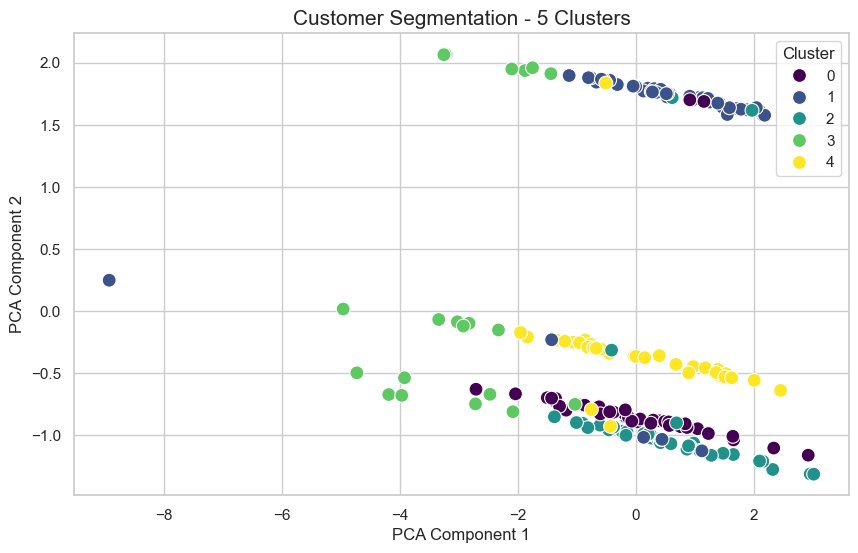

Cluster Evaluation Metrics:
   n_clusters  DB_Index  Silhouette_Score       ARI  V_Measure
0           2  1.727022          0.225338  0.122014   0.022697
1           3  1.263140          0.374489  0.122014   0.225171
2           4  0.875988          0.495234  0.122014   0.553762
3           5  0.804005          0.525845  0.122014   0.443154
4           6  0.817375          0.488918  0.122014   0.415825
5           7  0.875868          0.486363  0.122014   0.418119
6           8  0.761537          0.467615  0.122014   0.405665
7           9  0.803394          0.470974  0.122014   0.393570
8          10  0.790296          0.459926  0.122014   0.375084

Optimal number of clusters: 5
Davies-Bouldin Index for optimal clusters: 0.80
Silhouette Score for optimal clusters: 0.53
V-Measure for optimal clusters: 0.44


In [194]:
# Ensure that final_clusters has the same length as pca_features
if len(final_clusters) < len(pca_features):
    pca_features = pca_features[:-1]  
elif len(final_clusters) > len(pca_features):
    final_clusters = final_clusters[:-1]  

# Visualize clustering results using PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=final_clusters, palette='viridis', s=100)
plt.title(f'Customer Segmentation - {optimal_clusters} Clusters', fontsize=15)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()

# Print cluster evaluation metrics
print("Cluster Evaluation Metrics:")
print(cluster_metrics)
print(f"\nOptimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index for optimal clusters: {cluster_metrics.loc[cluster_metrics['n_clusters'] == optimal_clusters, 'DB_Index'].values[0]:.2f}")
print(f"Silhouette Score for optimal clusters: {cluster_metrics.loc[cluster_metrics['n_clusters'] == optimal_clusters, 'Silhouette_Score'].values[0]:.2f}")
print(f"V-Measure for optimal clusters: {cluster_metrics.loc[cluster_metrics['n_clusters'] == optimal_clusters, 'V_Measure'].values[0]:.2f}")


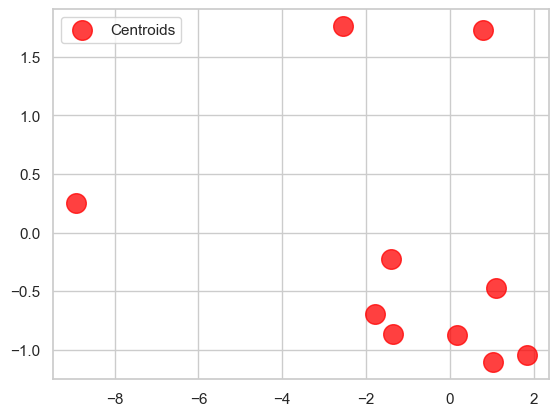

In [195]:
centroids = kmeans.cluster_centers_
pca_centroids = pca.transform(centroids)
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], c='red', s=200, alpha=0.75, label='Centroids')
plt.legend()


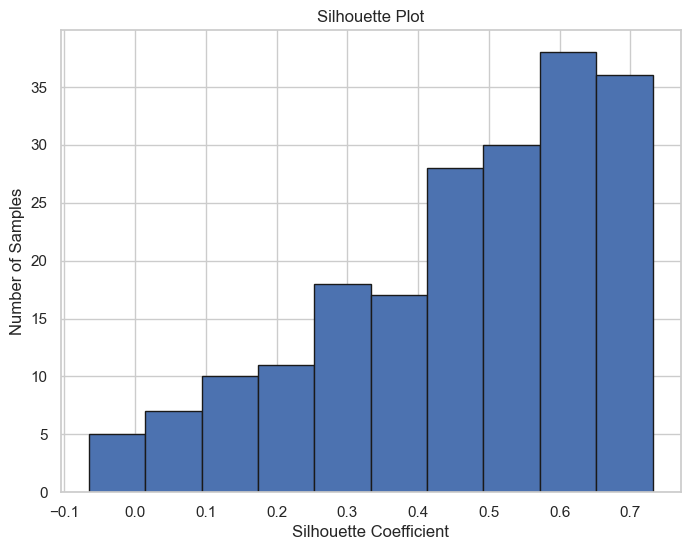

Average Silhouette Score: 0.46106703161734797


In [196]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Calculate silhouette scores for each sample
silhouette_values = silhouette_samples(scaled_features, clusters)

# Create silhouette plot
plt.figure(figsize=(8, 6))
plt.hist(silhouette_values, bins=10, edgecolor='k')
plt.title("Silhouette Plot")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Number of Samples")
plt.show()

avg_silhouette = silhouette_score(scaled_features, clusters)
print(f"Average Silhouette Score: {avg_silhouette}")


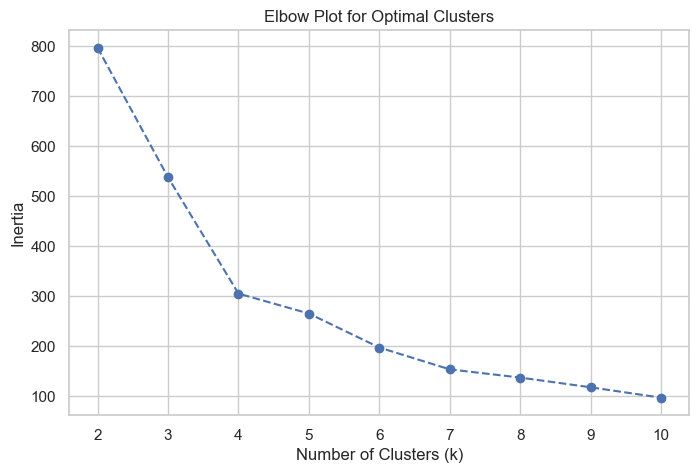

In [223]:
inertia_values = []

# Iterate through the range of possible cluster numbers (2 to 10 clusters in this case)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)  # Use pca_features for clustering, assuming PCA has been applied
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia_values, marker='o', linestyle='--')
plt.title('Elbow Plot for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()